# HarvestStat Data Profiling - DRC

In [1]:
from functools import reduce
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Congo, The Democratic Republic of the'
country_iso2 = 'CD'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32732' # DRC
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_CD.csv is loaded.


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Replace season name
df['season_name'] = df['season_name'].replace({
    'Harvest': "Main"
})
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([CD_Admin1_2015, CD_Admin3_1997, CD_Admin2_1997], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 7,419
Removed 4,661 "Missing Value" points
324/2,473 "Area Planted" points are retained.
2,110/2,473 "Quantity Produced" points are retained.
324/2,473 "Yield" points are retained.
Current data points: 2,758

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2005 - 2016
5 grain types are found: Beans (mixed), Cassava, Cooking Banana (unspecified), Maize (Corn), Rice (Paddy)
1 seasons are found: Main (01-01)
1 crop production system are found: none
Data sources include:
[1] CCSAP/SIG, Congo, The Democratic Republic of the --- Crop and food security assessment mission, DRC
[2] SNSA, Congo, The Democratic Republic of the --- Annuaire des Statistiques Agricoles (2006-2011), DRC
Administrative-1 fnids: 21
Administrative-2 fnids: 39
0 reporting units are found: 

- Total production over time ------------------ #
season_name                    Main
          

- Recorded years per season ------------------- #
Main: 12 years (2005-2016) (missing: 1 years)

- Number of "Quantity Produced" data points --- #
CD1997A2: 1,146 data points are found.
CD1997A3: 640 data points are found.
CD2015A1: 324 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.

Table of available data


----------------------------------------------- #
Crop type: Beans (mixed)
----------------------------------------------- #
season_name              Main        
crop_production_system   none        
fnid_short             1997A2  1997A3
year                                 
2005                    25/47  20/164
2006                    25/47  20/164
2007                    25/47  20/164
2008                    25/47  20/164
2009                    25/47  20/164
2010                    25/47  20/164
2011                    24/47  20/164
----------------------------------------------- #
Crop type: Cassava
----------------------------------------------- #
season_name              Main               
crop_production_system   none               
fnid_short             1997A2  1997A3 2015A1
year                                        
2005                    39/47  22/164    NaN
2006                    33/47  22/164    NaN
2007                    33/47  22/164    NaN
2008                   

../figures/CD_admin_shapes.png is saved.


- DRC crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-drc.png" width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/safrica_cg_calendar.png" width=900><br>

<img src="../figures/crop_calendar/seasonal-calendar-drc-fao.jpg" width=900>

- FDW data consists of `CD1997A2`, `CD1997A3`, and `CD2015A1`.

| Year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| :---: | :----:   | :----:   | :----:   | :---:   |  :----:   | :---:   |
| 1997	 | CD1997A1 | 11	| CD1997A2	| 47	| CD1997A3	| 164	|
| 2007	 | CD2007A1 | 11	| CD2007A2	| 47	| CD2007A3	| 164	|
| 2015	 | **`CD2015A1`** | 26	| CD2015A2	| 241	| nan	| 0	|
| 2017	 | CD2017A1 | 26	| CD2017A2	| 240	| nan	| 0	|

- Comparison between admin boundaries.

<img src="../figures/CD_admin_shapes.png" width=900>

- DRC has both admin-2 and admin-3 level data from 2005 to 2011. So, it is important to check any duplicated data over the same region.
    - admin-3 level data only exists in `Maniema`, `North Kivu`, and `South Kivu`, and there is no overlap with admin-2 level data (confirmed by Donghoon).
- In 2015, Admin-2 level became Admin-1 level with some aggregation (mostly city boundaries are merged).
- **`CD2015A1`** is used to represent the current admin-level 1 crop data.
- DRC has a single crop season: `Main` (name is changed from `Harvest`).
- DRC has no population group(s).

In [4]:
# Check overlap between admin2 and admin3 ------- #
df['adm_level'] = df['fnid'].apply(lambda x: x[6:8])
a2 = df[df['adm_level'] == 'A2']
a3 = df[df['adm_level'] == 'A3'] # 'Maniema', 'North Kivu', 'South Kivu
assert np.isin(a3['admin_1'].unique(), a2['admin_1'].unique()).sum() == 0

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = CD_Admin1_2015.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# Manual change
idx = shape_used['FNID'].apply(lambda x: x[6:8] == 'A3')
shape_used.loc[idx, 'name'] = shape_used.loc[idx, 'ADMIN3']
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Aggregation to lower admin level -------------- #
# Remove duplicated districts in admin-3 shapefile as no crop data there
duplicated = CD_Admin3_1997['FNID'].value_counts()
fnid_duplicated = duplicated.index[duplicated > 1]
assert df['fnid'].isin(fnid_duplicated).sum() == 0
CD_Admin3_1997 = CD_Admin3_1997[~CD_Admin3_1997['FNID'].isin(fnid_duplicated)].reset_index(drop=True)
# We aggregate admin-3 and admin-2 data to admin-1 data
# Generate AdminLink manually
from tools import CreateLinkAdmin, invert_dicts
link_1997a, _, _ = CreateLinkAdmin(CD_Admin1_2015, CD_Admin3_1997, old_on='ADMIN1', new_on='ADMIN3')
link_1997a = invert_dicts(link_1997a)
link_1997b, _, _ = CreateLinkAdmin(CD_Admin1_2015, CD_Admin2_1997, old_on='ADMIN1', new_on='ADMIN2')
link_1997b = invert_dicts(link_1997b)
assert link_1997a.keys() == link_1997b.keys()
link = {}
for fnid in link_1997a.keys():
    link[fnid] = [*link_1997a[fnid], *link_1997b[fnid]]
# Connect data with AdminLink
area_new = []
prod_new = []
for fnid in link.keys():
    area_merged = [area[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    area_merged = reduce(lambda a, b: a.add(b, fill_value=0), area_merged)
    area_merged.columns = area[fnid].columns
    area_merged = pd.concat([area_merged], keys=[fnid], names=['fnid'], axis=1)
    area_new.append(area_merged)
    prod_merged = [prod[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    prod_merged = reduce(lambda a, b: a.add(b, fill_value=0), prod_merged)
    prod_merged.columns = prod[fnid].columns
    prod_merged = pd.concat([prod_merged], keys=[fnid], names=['fnid'], axis=1)
    prod_new.append(prod_merged)
area_new = pd.concat(area_new, axis=1)
prod_new = pd.concat(prod_new, axis=1)
assert area.sum().sum().round() == area_new.sum().sum().round()
assert prod.sum().sum().round() == prod_new.sum().sum().round()
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


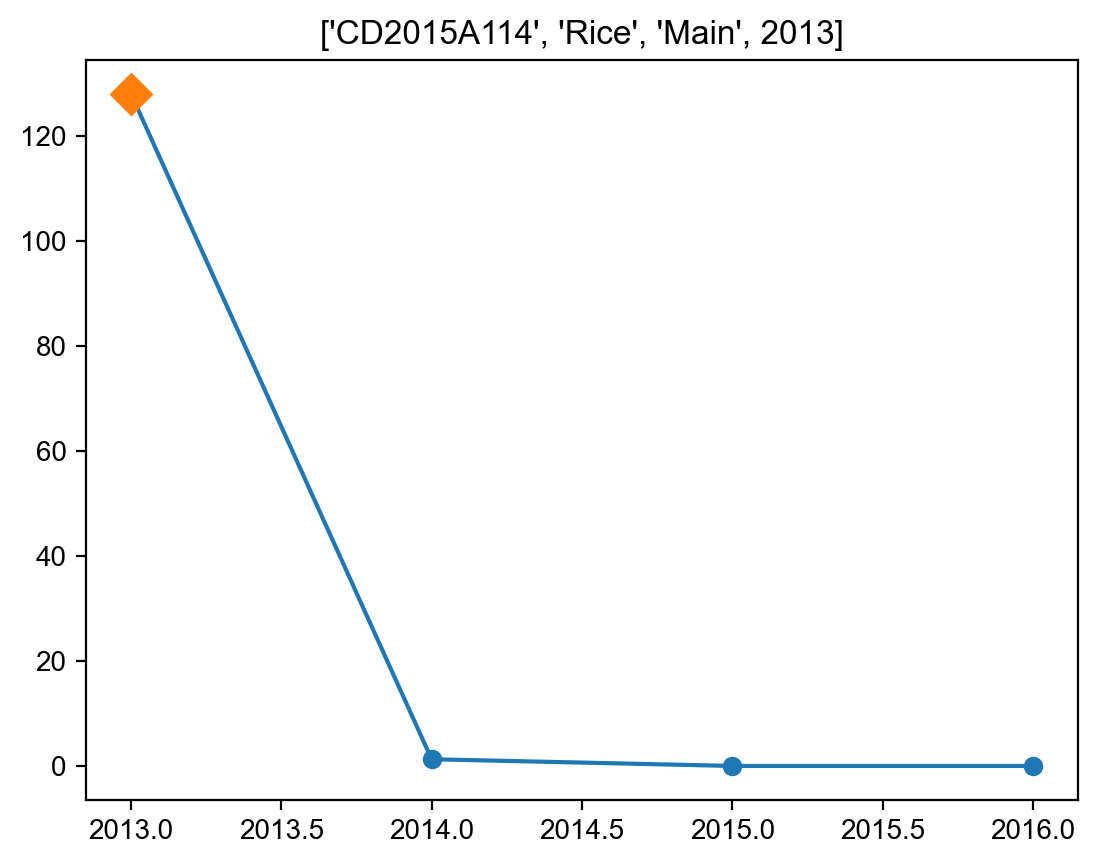

In [8]:
from matplotlib import pyplot as plt

outliers = [
            ['CD2015A114','Rice','Main',2013],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then flag the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1  
    

In [9]:
# Save data
fn_out = '../data/crop/adm_crop_production_CD.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

../data/crop/adm_crop_production_CD.csv is saved.


## Visualization of production data

/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


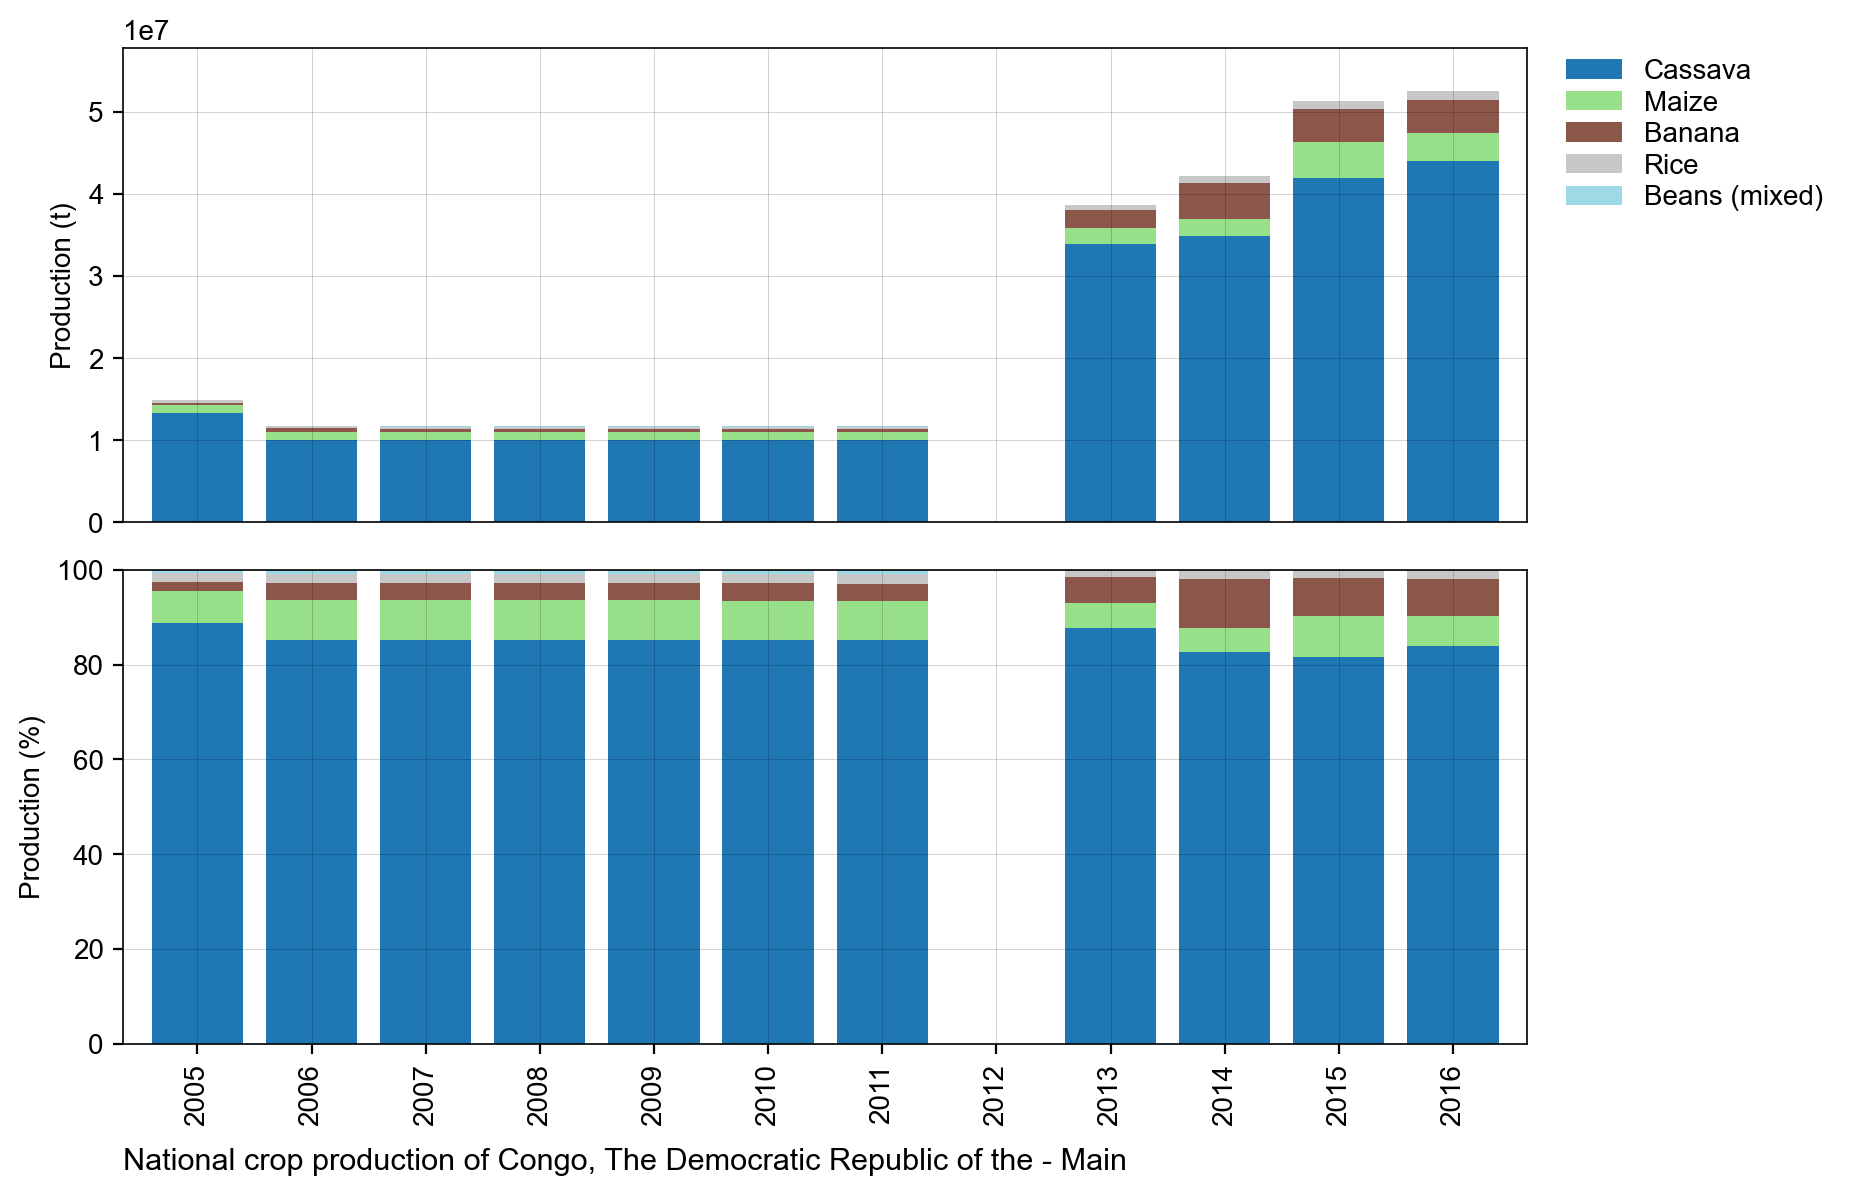

../figures/CD_bar_natgrainprod_Main.png is saved.


In [10]:
# Bar chart of national crop production
country_iso, country_name = 'CD', 'Congo, The Democratic Republic of the'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

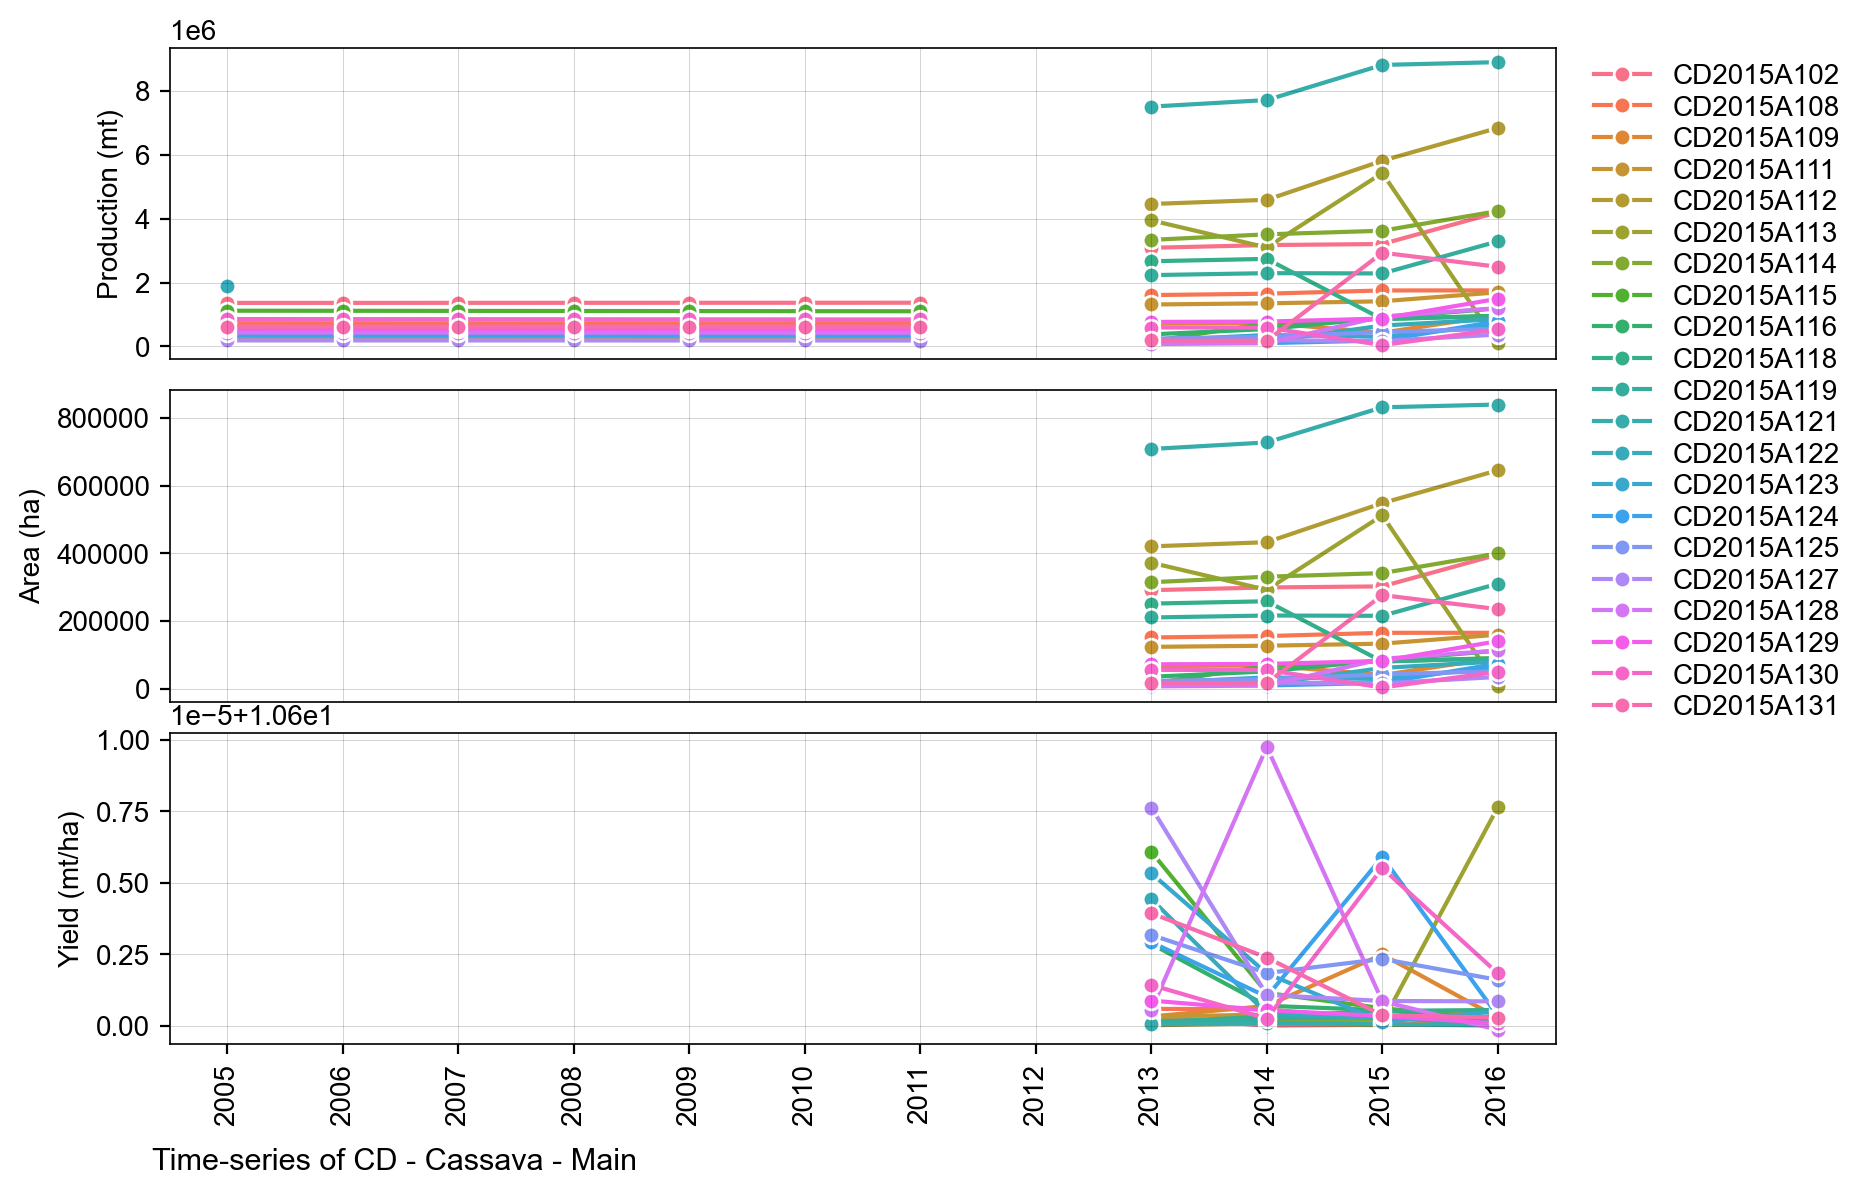

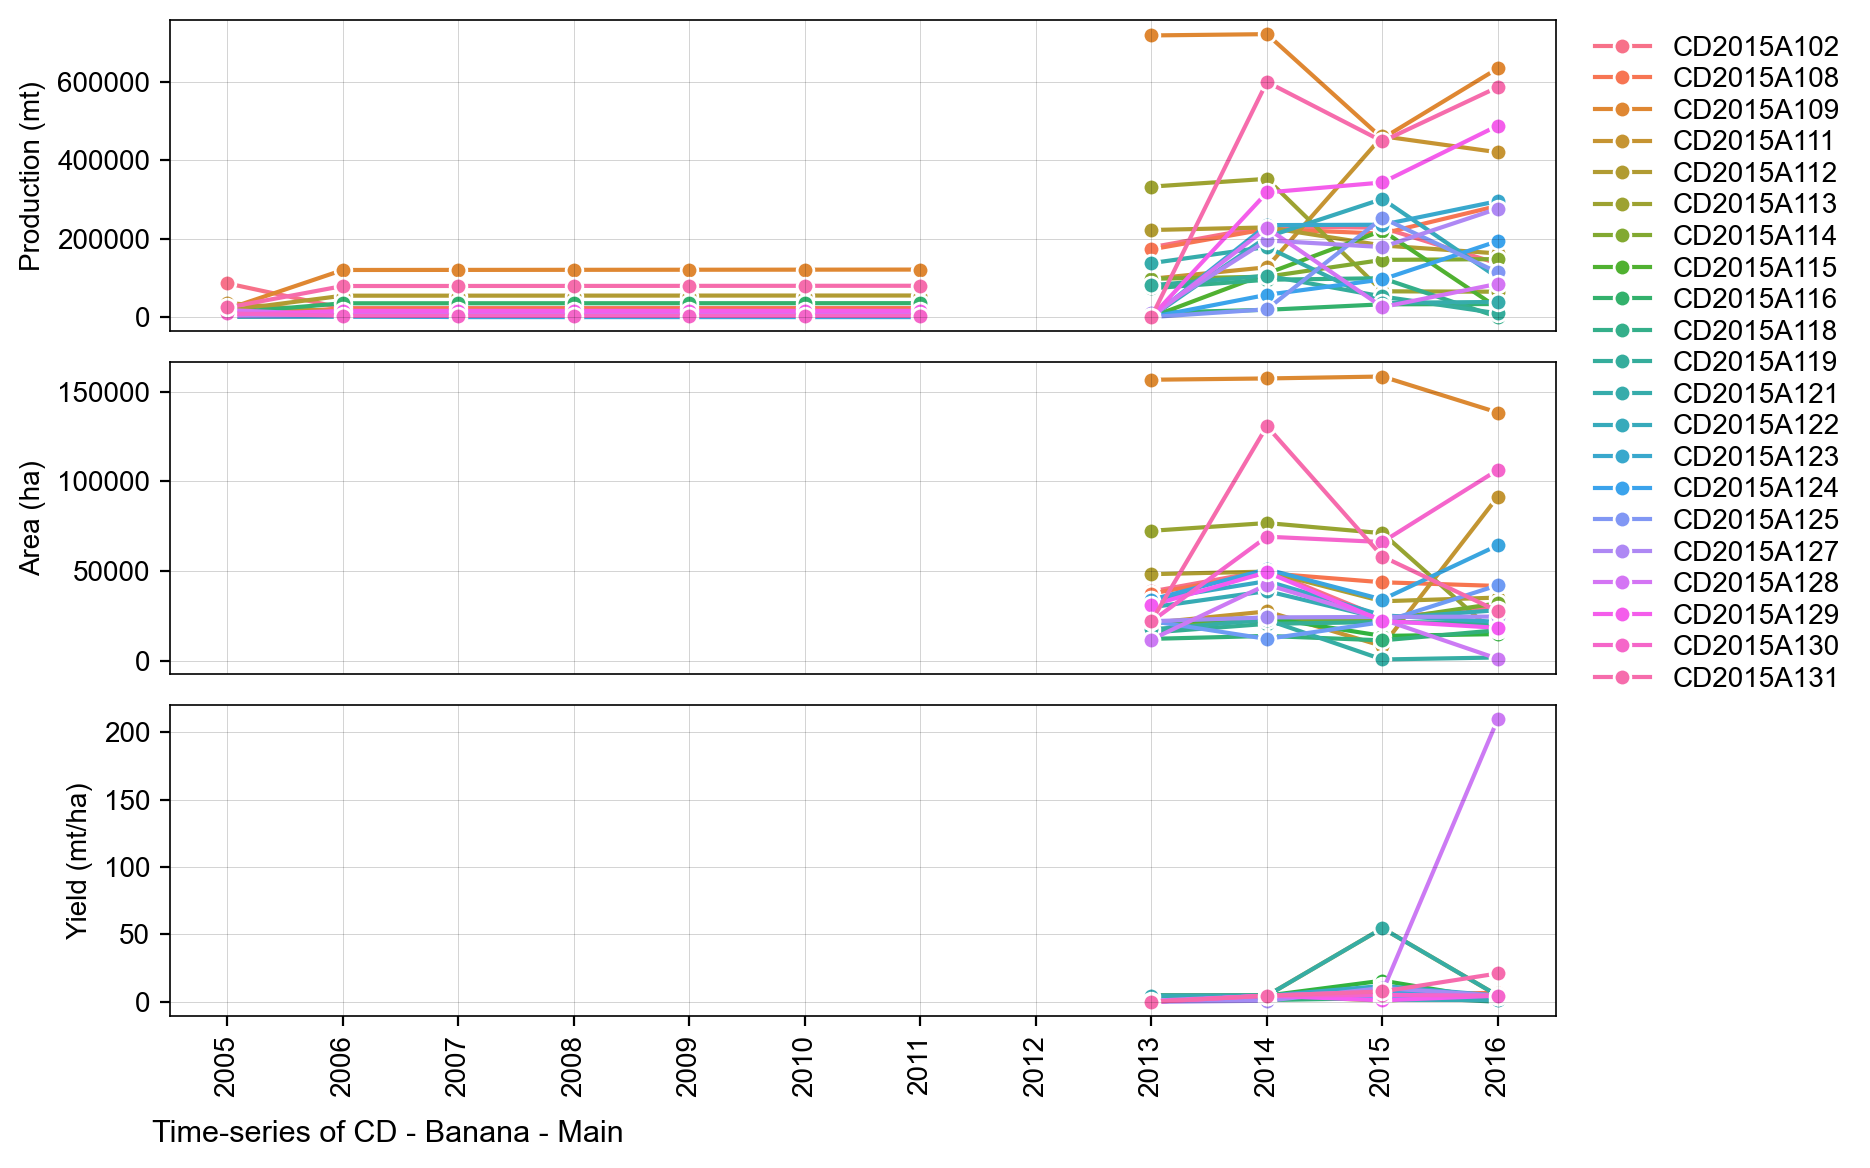

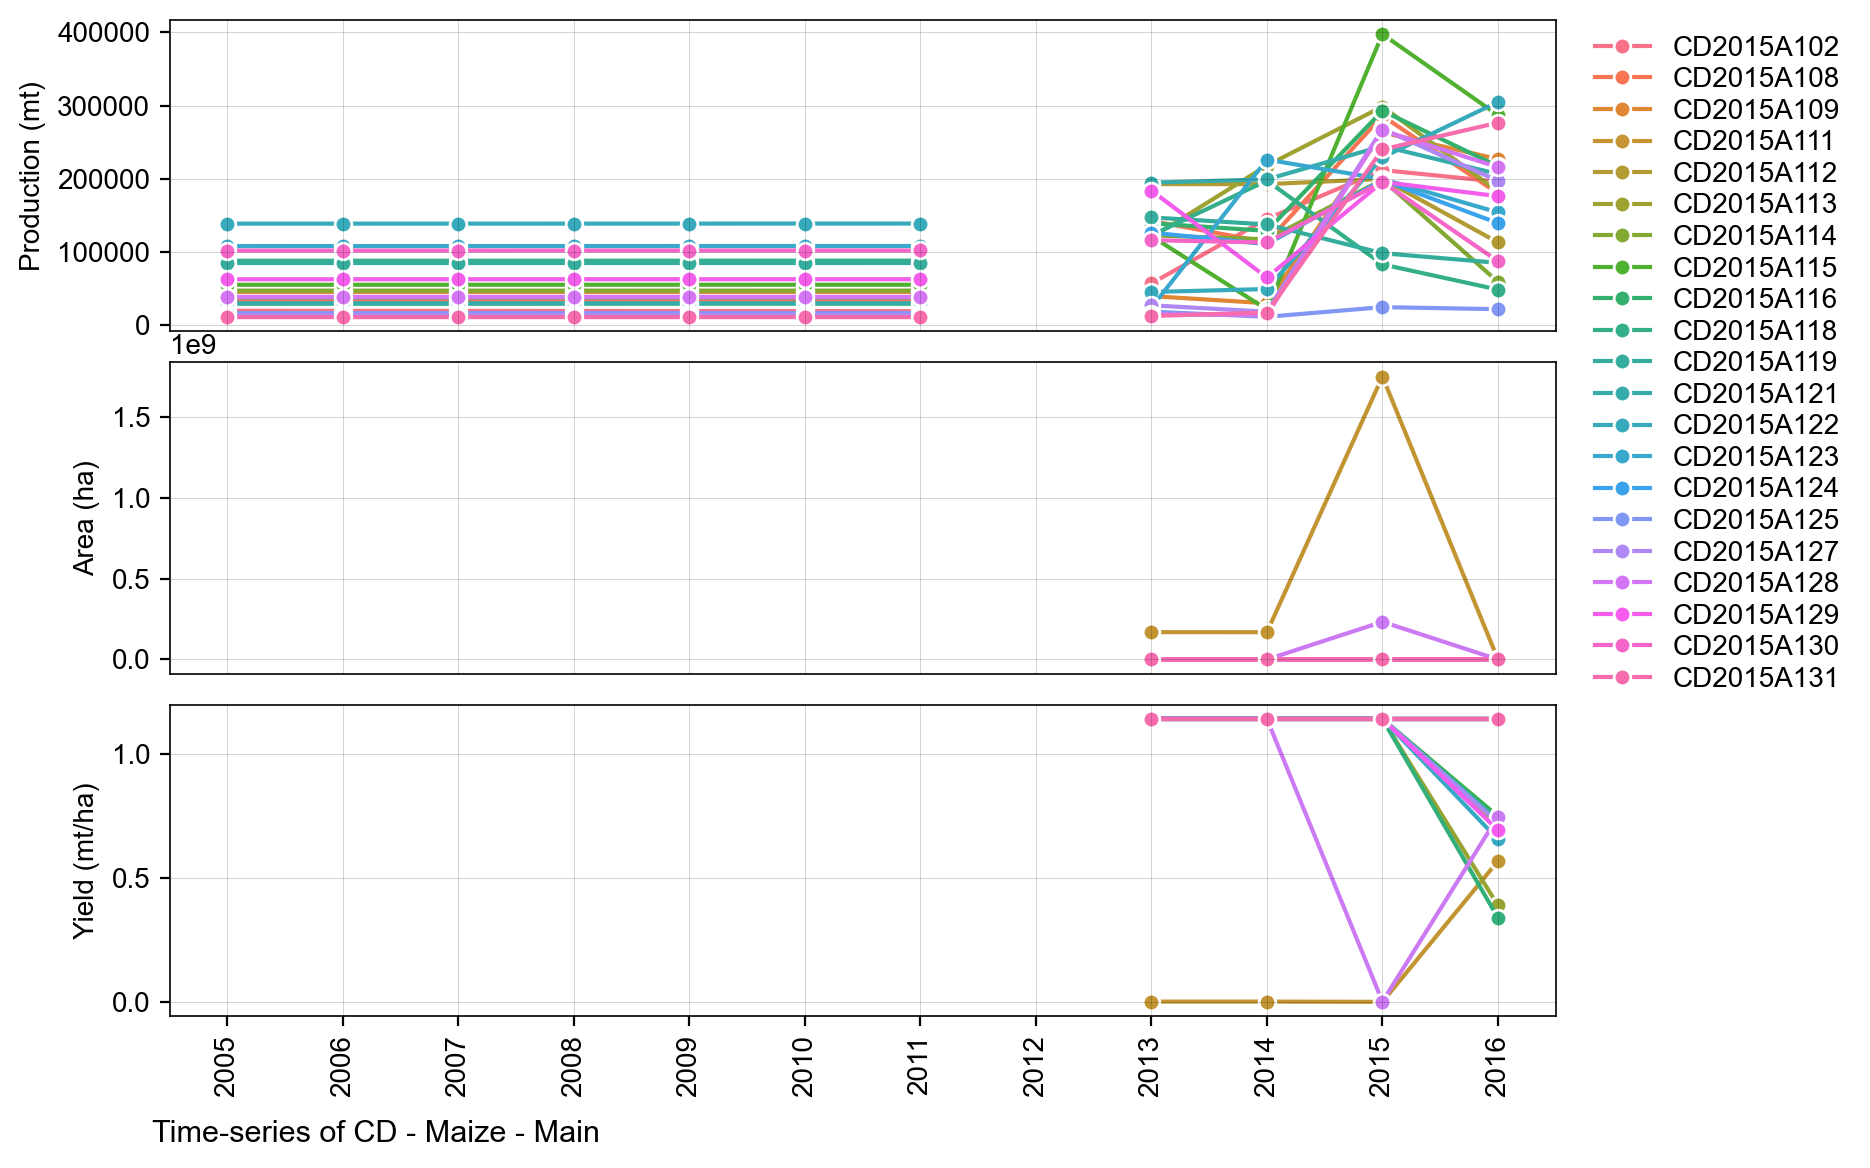

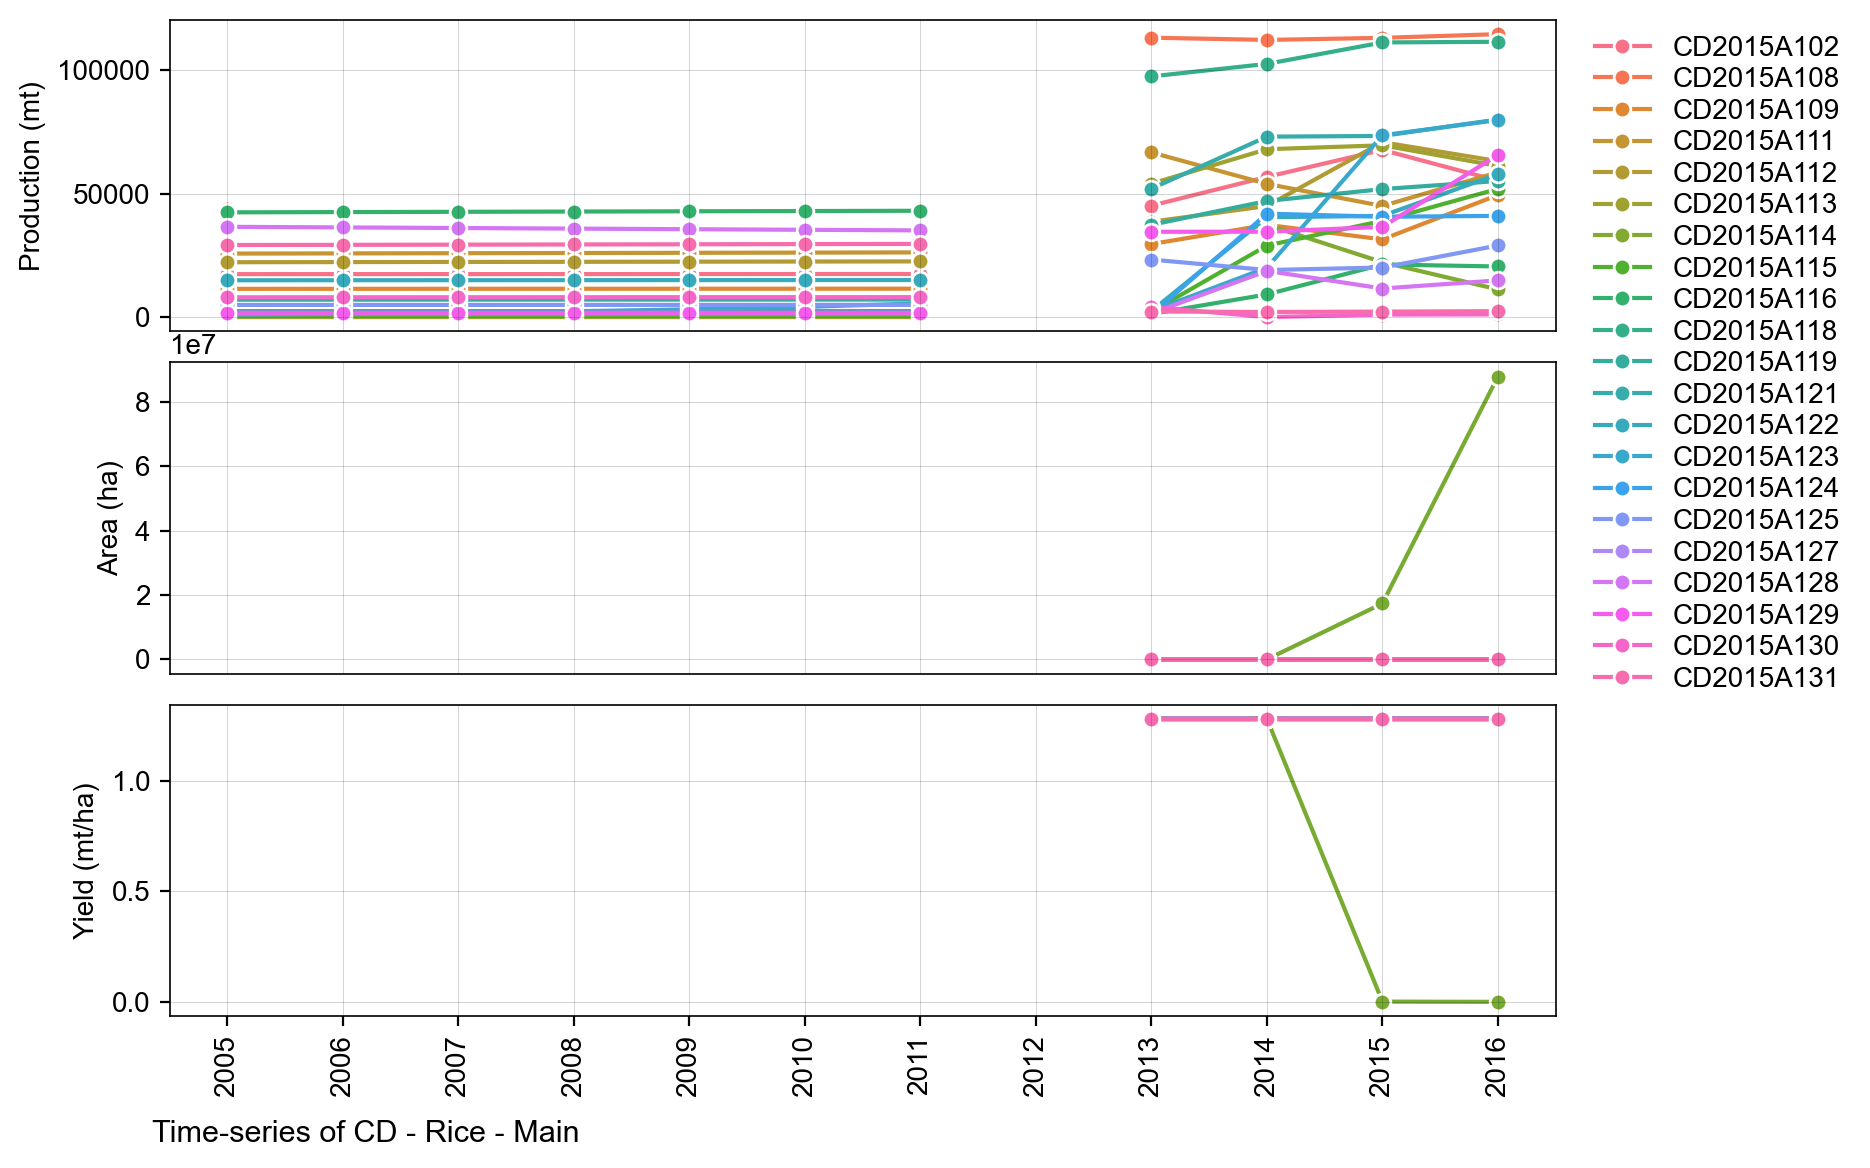

In [11]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'CD', 'Congo, The Democratic Republic of the'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava','Main'],
    ['Banana','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    if len(sub['year'].unique()) < 1: continue
    PlotLinePAY(sub, year, footnote)